# Clustering notebook

This notebook contains the simple examples of timeseries clustering using ETNA library.

**Table of Contents**

* [Generating dataset](#chapter1)  
* [Clustering](#chapter2)
    * [Build Distance Matrix](#section_2_1)
    * [Custom Distance](#section_2_2)
    * [Build Clustering algorithm](#section_2_3)
    * [Predict clusters](#section_2_4)
    * [Get centroids](#section_2_5)

In [1]:
import warnings
warnings.filterwarnings("ignore")

## 1. Generating dataset <a class="anchor" id="chapter1"></a>

In this notebook we will work with the toy dataset generated from Normal distribution. Timeseries are naturally separated into clusters based on the mean value.

In [2]:
from etna.datasets import TSDataset
import pandas as pd
import numpy as np

In [3]:
def gen_dataset():
    df = pd.DataFrame()
    for i in range(1, 4):
        date_range = pd.date_range("2020-01-01", "2020-05-01")
        for j, sigma in enumerate([0.1, 0.3, 0.5, 0.8]):
            tmp = pd.DataFrame({"timestamp": date_range})
            tmp["segment"] = f"{2*i}{j}"
            tmp["target"] = np.random.normal(2*i, sigma, len(tmp))
            df = df.append(tmp, ignore_index=True)
    ts = TSDataset(df=TSDataset.to_dataset(df), freq="D")
    return ts

Let's take a look at the dataset

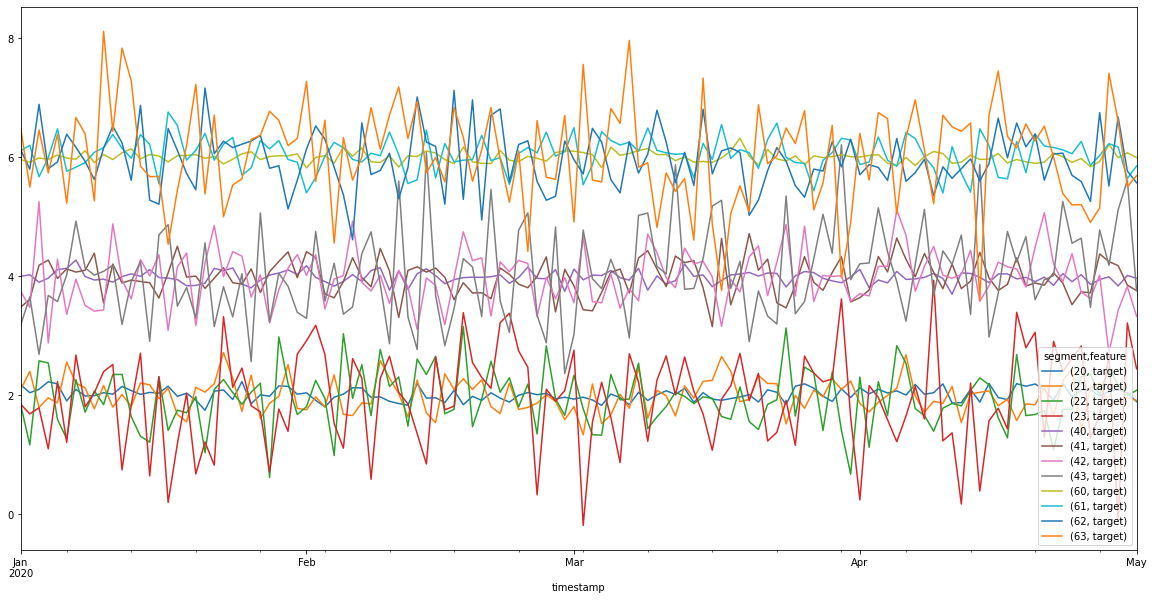

In [4]:
ts = gen_dataset()
ts.df.plot(figsize=(20,10));

As you can see, there are about three clusters here. However, usually it is not obvious how to separate the timeseries into the clusters. Therefore, we might want to use clustering algorithms to help us.

## 2. Clustering <a class="anchor" id="chapter2"></a>

Our library provides a class for so called *hierarchical clustering*, which has two built-in implementations for different Distances. 

In [5]:
from etna.clustering import EuclideanClustering,DTWClustering

In this section you will find the description of step by step clustering process. 

### 2.1 Build Distance Matrix<a class="anchor" id="section_2_1"></a>

On the first step we need to build the so-called *Distance matrix* containing the pairwise distances between the timeseries in the dataset. Note, that this is the most time-consuming part of the clustering process, and it may take a long time to build a Distance matrix for a large dataset.

In [6]:
import seaborn as sns

Distance matrix for the Euclidean distance

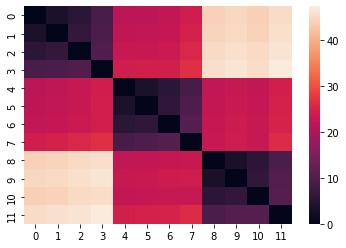

In [7]:
model = EuclideanClustering()
model.build_distance_matrix(ts=ts)
sns.heatmap(model.distance_matrix.matrix);

Distance matrix for the DTW distance

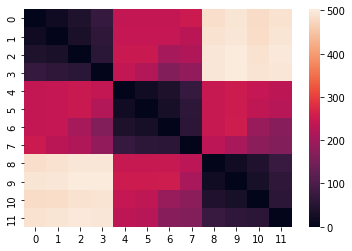

In [8]:
model = DTWClustering()
model.build_distance_matrix(ts=ts)
sns.heatmap(model.distance_matrix.matrix);

The Distance matrix is computed ones and saved in the instance of `HierarchicalClustering`. 

### 2.2 Custom Distance<a class="anchor" id="section_2_2"></a>

In addition to the built-in Distances, you are able to implement your own Distance. The example below shows how to implement the custom Distance.

In [9]:
from etna.clustering import Distance
from etna.clustering import HierarchicalClustering

class MyDistance(Distance):
    
    def __init__(self):
        super().__init__()

    def _compute_distance(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """Compute distance between x1 and x2."""
        return np.max(np.abs(x1-x2))

    def _get_average(self, ts: "TSDataset") -> pd.DataFrame:
        """Get series that minimizes squared distance to given ones according to the distance."""
        centroid = pd.DataFrame({"timestamp": ts.index.values, "target": ts.df.median(axis=1).values})
        return centroid

To specify the Distance in clustering algorithm you need to use the clustering base class `HierarchicalClustering`

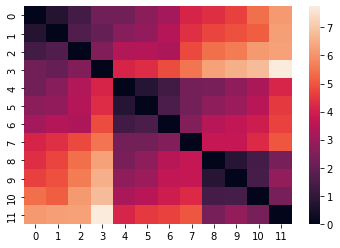

In [10]:
model = HierarchicalClustering()
model.build_distance_matrix(ts=ts,distance=MyDistance())
sns.heatmap(model.distance_matrix.matrix);

### 2.3 Build Clustering algorithm <a class="anchor" id="section_2_3"></a>

After computing the Distance matrix, you need to set the parameters to the clustering algorithm, such as:
+ **n_clusters** - number of clusters
+ **linkage** - rule for distance computation for new clusters  

As the Distance matrix is build once, you can experiment with different parameters of the clustering algorithm without wasting time on its recomputation. 

In [11]:
model = EuclideanClustering()
model.build_distance_matrix(ts)

In [12]:
model.build_clustering_algo(n_clusters=3,linkage="average")

### 2.4 Predict clusters<a class="anchor" id="section_2_4"></a>

The final step of the clustering process is cluster prediction. As the output of the `fit_predict` you get the mapping for segment to cluster.

In [13]:
segment2cluster = model.fit_predict()

Let's visualize the results

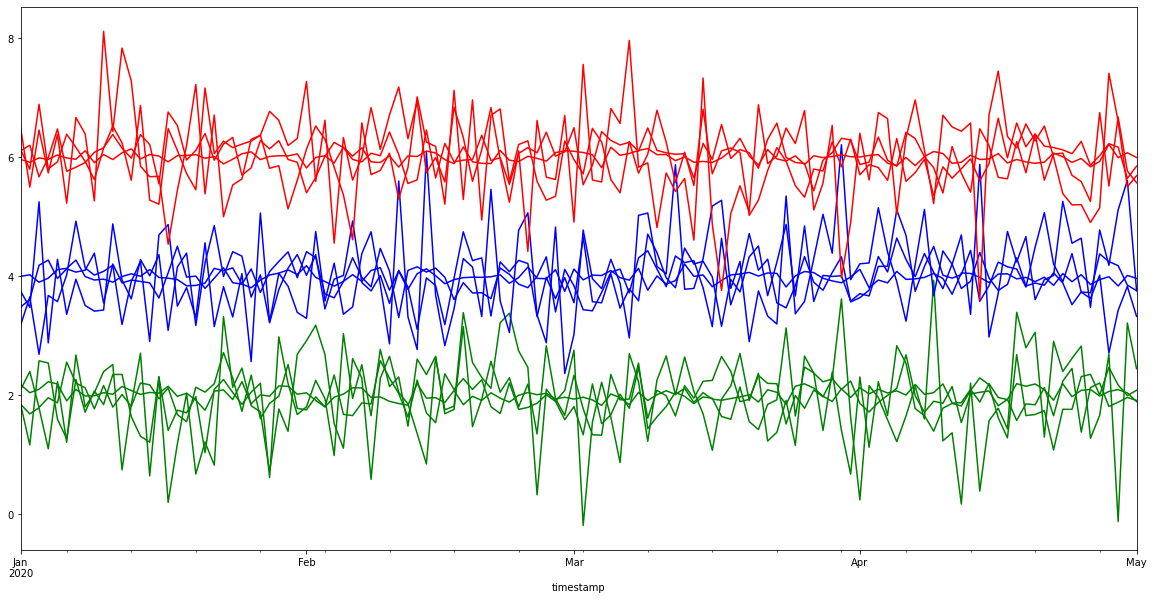

In [14]:
colores = ['r','g','b']
color = [colores[i] for i in segment2cluster.values()]
ts.df.plot(figsize=(20,10),color=color,legend=False);

### 2.5 Get centroids<a class="anchor" id="section_2_5"></a>

In addition, it is possible to get the clusters centroids, which are the typical member of the corresponding cluster.

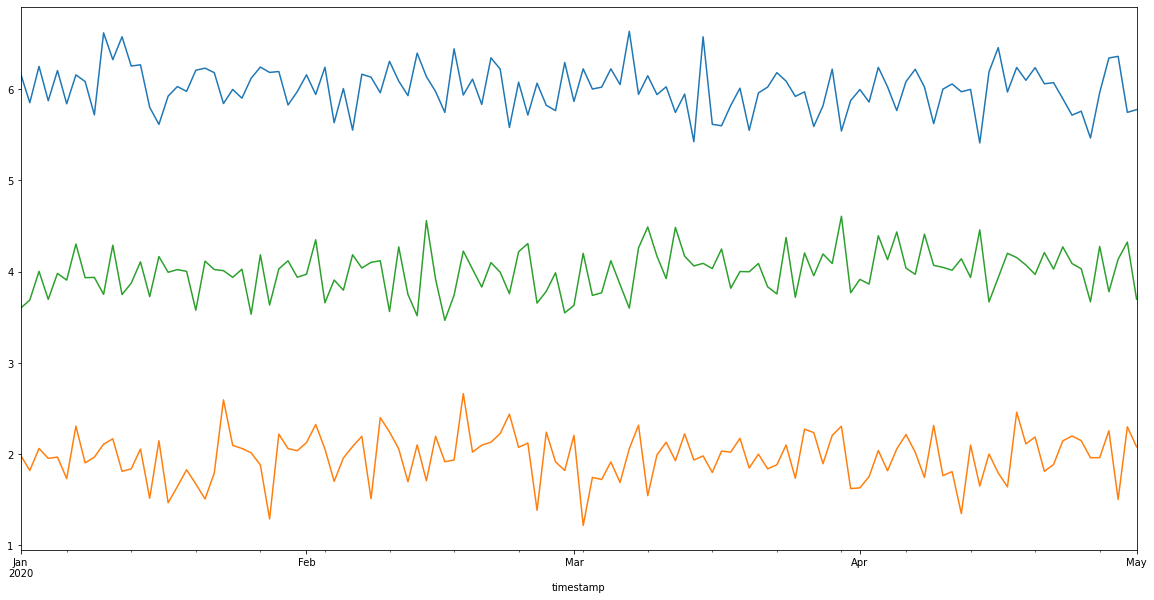

In [15]:
centroids = model.get_centroids()
centroids.plot(figsize=(20,10),legend=False);